# Projet 6 : Classifiez automatiquement des biens de consommation
Etude de la faisabilité d'un moteur de classification sur des biens de consommation.

Les informations dont nous disposons sont la description texte du produit et sa photo.
- Nous allons tenter d'extraire des variables depuis ces données 
- Ces variables seront ensuites utilisées passées à un algorithme de clustering

### La capacité de l'algorithme à partitionner efficament les produits nous permettra d'informer une décision : est-il faisable d'entrainer un modèle de classification ? 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import spacy
import gensim
import gensim.corpora as corpora
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.cluster import adjusted_rand_score
import warnings
import time
import cv2
import keras
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.models import Model
from wordcloud import WordCloud

Nous commençons par charger les données en mémoire.


In [2]:
data = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

In [3]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
uniq_id,1050,1050,55b85ea15a1536d46b7190ad6fff8ce7,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
crawl_timestamp,1050,149,2015-12-01 12:40:44 +0000,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_url,1050,1050,http://www.flipkart.com/elegance-polyester-mul...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_name,1050,1050,Elegance Polyester Multicolor Abstract Eyelet ...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_category_tree,1050,642,"[""Home Furnishing >> Bed Linen >> Blankets, Qu...",56,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pid,1050,1050,CRNEG7BKMFFYHQ8Z,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
retail_price,1049.0,NaN,NaN,NaN,2186.197331,7639.229411,35.0,555.0,999.0,1999.0,201000.0
discounted_price,1049.0,NaN,NaN,NaN,1584.527169,7475.09968,35.0,340.0,600.0,1199.0,201000.0
image,1050,1050,55b85ea15a1536d46b7190ad6fff8ce7.jpg,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_FK_Advantage_product,1050,2,False,993,NaN,NaN,NaN,NaN,NaN,NaN,NaN


La plupart de ces variables ne sont pas pertinentes à notre problématique, nous nous en débarassons.

In [4]:
data.drop(['uniq_id',
           'crawl_timestamp',
           'product_url',
           'pid',
           'retail_price',
           'discounted_price',
           'is_FK_Advantage_product',
           'product_rating',
           'overall_rating',
           'brand',
           'product_specifications'],
          axis=1,
          inplace=True)

In [5]:
data.sample(5)

,product_name,product_category_tree,image,description
191,"Prithish Blue & Gold Heart, I Love You Ceramic...","[""Kitchen & Dining >> Coffee Mugs >> Prithish ...",ce2f67c3365846170cb709784d87e45b.jpg,"Buy Prithish Blue & Gold Heart, I Love You Cer..."
853,RRP Lamp For Computer Keyboard Tslplt02 USB Le...,"[""Computers >> Laptop Accessories >> USB Gadge...",146b0d570d5ab4e27629d48533b7680d.jpg,RRP Lamp For Computer Keyboard Tslplt02 USB Le...
864,RCE HP ProBook 4430s 6 Cell Laptop Battery,"[""Computers >> Laptop Accessories >> Batteries...",19d2dbc1789653c58bce08c169662cf2.jpg,Buy RCE HP ProBook 4430s 6 Cell Laptop Battery...
85,Smart Wall Guru Medium Adhesive Sticker,"[""Home Decor & Festive Needs >> Wall Decor & C...",61c0139f3d5c97f1615797dbf046cc0c.jpg,Key Features of Smart Wall Guru Medium Adhesiv...
824,SWHF Cotton Maroon Striped Eyelet Window & Doo...,"[""Home Furnishing >> Curtains & Accessories >>...",0ec47240feda42c63e42f1e9cee60f7a.jpg,SWHF Cotton Maroon Striped Eyelet Window & Doo...


L'objectif est porté sur la prédiction de la **catégorie** d'un article

In [6]:
[print(description) for description in data['product_category_tree'][0:4]][0]

["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]
["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]
["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]
["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]


Nous pouvons observer que ces dernières ont une organisation hiérarchique
- quel niveau de catégorie utiliser pour notre étude ? 

Nous découpons les différentes catégories grâce au séparateur ">>"

In [7]:
splitted_categories = [re.split('>>',categoryTree) for categoryTree in data['product_category_tree']]

In [8]:
# Nous considérons seulement les 2 premiers niveaux car pas tous les produits ne contiennent 3 niveaux de précision
firstLevel = [re.sub('\W','',splitted_categories[i][0]) for i in range(0,len(splitted_categories))]
secondLevel = [re.sub('\W','',splitted_categories[i][1]) for i in range(0,len(splitted_categories))]

In [9]:
def plot_levels(levels):
    plotData = pd.Series(levels).value_counts()
    sns.barplot(x = plotData.values,
                y= plotData.index)

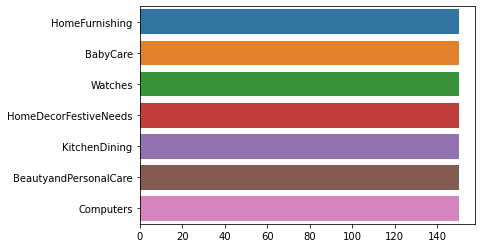

In [10]:
plot_levels(firstLevel)

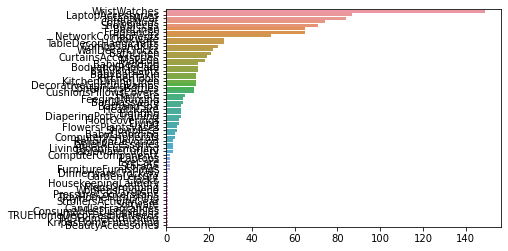

In [11]:
plot_levels(secondLevel)

- Nous avons pour le premier niveau 7 catégories aux quantités d'instances identiques
- le Deuxième niveau est quant à lui composé de classes très déséquilibrés. 

#### Nous allons pour notre tâche nous baser sur le premier niveau de classification

In [12]:
data['category'] = firstLevel

In [13]:
data.drop('product_category_tree',
          axis=1, 
          inplace=True)
data

,product_name,image,description,category
0,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,HomeFurnishing
1,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,BabyCare
2,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,BabyCare
3,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,HomeFurnishing
4,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,HomeFurnishing
...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Oren Empower Extra Large Self Adhesive Sticker...,BabyCare
1046,Wallmantra Large Vinyl Sticker Sticker,fd6cbcc22efb6b761bd564c28928483c.jpg,Wallmantra Large Vinyl Sticker Sticker (Pack o...,BabyCare
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,5912e037d12774bb73a2048f35a00009.jpg,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,BabyCare
1048,Wallmantra Medium Vinyl Sticker Sticker,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,BabyCare


Nous regroupons les données texte entre elles : le titre + sa description

In [14]:
data['text_data'] = data['product_name'] + data['description']
data.drop(['product_name',
           'description'],
           axis=1,
           inplace=True)

In [15]:
data

,image,category,text_data
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,HomeFurnishing,Elegance Polyester Multicolor Abstract Eyelet ...
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,BabyCare,Sathiyas Cotton Bath TowelSpecifications of Sa...
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,BabyCare,Eurospa Cotton Terry Face Towel SetKey Feature...
3,d4684dcdc759dd9cdf41504698d737d8.jpg,HomeFurnishing,SANTOSH ROYAL FASHION Cotton Printed King size...
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,HomeFurnishing,Jaipur Print Cotton Floral King sized Double B...
...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,BabyCare,Oren Empower Extra Large Self Adhesive Sticker...
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,BabyCare,Wallmantra Large Vinyl Sticker StickerWallmant...
1047,5912e037d12774bb73a2048f35a00009.jpg,BabyCare,Uberlyfe Extra Large Pigmented Polyvinyl Films...
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,BabyCare,Wallmantra Medium Vinyl Sticker StickerBuy Wal...


## Encodage des labels
afin de pouvoir mesurer les performance d'un modèle de clustering nous allons numériquement encoder les catégories de produits

In [16]:
le = LabelEncoder()
data['encodedLabels'] = le.fit_transform(data['category'])
data.sample(5)

,image,category,text_data,encodedLabels
822,3fd4d7ea04624ada39fde3957c7b9b7c.jpg,HomeDecorFestiveNeeds,Bharatcraft Wall Hanging Of Lord Ganesha On A ...,3
260,04f9f818e2d657b873b07578cfe2eade.jpg,HomeDecorFestiveNeeds,Monil Cow With Calf Showpiece - 10.2 cmBuy M...,3
221,81a695f80d3f5c445910d310f1a83eb8.jpg,HomeDecorFestiveNeeds,S C Handicrafts Sandalwood Chinese Queen. Show...,3
419,e365b55f806e5d0abe0094a9f2590e33.jpg,Computers,Tenda 3G622R+Buy Tenda 3G622R+ only for Rs. 35...,2
916,c5c559012b742d9966df82182b90c6da.jpg,HomeDecorFestiveNeeds,wallskart Floral & Botanical WallpaperKey Feat...,3


## Nettoyage du texte
Nous allons procéder à plusieurs étapes de nettoyage avant d'encoder nos données texte
- mettre tout en minuscule
- retirer la ponctuation
- retirer les mots "creux" non porteurs de sens
- lemmatiser

Chargement du modèle spacy pour les traitements

In [17]:
nlp = spacy.load("en_core_web_lg")

In [18]:
# cette fonction procède à un nettoyage du texte pour un document
def clean_text(text):
    doc = nlp(text)
    cleanText = []
    for token in doc:
        if not token.is_punct and not token.is_stop and not token.is_space :
            cleanText.append(token.lemma_.lower())
    return(' '.join(cleanText))

Nous pouvons ici observer la différence entre le texte orginal...

In [19]:
data['text_data'][10]

'Calibro SW-125 Analog-Digital Watch  - For Men, BoysCalibro SW-125 Analog-Digital Watch  - For Men, Boys\r\n                         Price: Rs. 699\r\n\t\t\t\t\r\n\t\t\tCALIBRO presents MTG Black Dial Round Watch. This is a fashionable watch from MTG that adds to your style statement. This brand is known for its usage of quality material in making appealing watches. It understands the needs of youth so well that it is able to present wide range of watches to its customers. The variety in design, style and youthful approach is very well executed by this brand. Get one and see how brilliantly it leads other brands in style, finish and everything else that matters.\r\nCALIBRO presents MTG Black Dial Round Watch. This is a fashionable watch from MTG that adds to your style statement. This brand is known for its usage of quality material in making appealing watches. It understands the needs of youth so well that it is able to present wide range of watches to its customers. The variety in d

...et sa version traitée par la fonction

In [20]:
clean_text(data['text_data'][10])

'calibro sw-125 analog digital watch men boyscalibro sw-125 analog digital watch men boy price r 699 calibro present mtg black dial round watch fashionable watch mtg add style statement brand know usage quality material make appeal watch understand need youth able present wide range watch customer variety design style youthful approach execute brand brilliantly lead brand style finish matter calibro present mtg black dial round watch fashionable watch mtg add style statement brand know usage quality material make appeal watch understand need youth able present wide range watch customer variety design style youthful approach execute brand brilliantly lead brand style finish matter'

In [21]:
# Cette fonction applique le nettoyage à un ensemble de documents
def clean_Series(Series):
    textList = [clean_text(doc) for doc in Series]
    return(pd.Series(textList))

Nous appliquons le nettoyage à l'ensemble des descriptions de produit

In [22]:
cleanDocs = clean_Series(data['text_data'])

Notre pré-traitement est fini mais nous pouvons voir que certaines parties du texte semblent génériques et peu utiles.

In [23]:
cleanDocs[6]

'camerii wm64 elegance analog watch men boyscamerii wm64 elegance analog watch men boys buy camerii wm64 elegance analog watch men boy wm64 online rs.449 india flipkart.com great discounts genuine products 30 day replacement guarantee free shipping cash delivery'

In [24]:
def print_most_common_token(Series):
    fullText = " ".join(string for string in Series)
    return(Counter(fullText.split()).most_common(20))

In [25]:
print_most_common_token(cleanDocs)

[('free', 622),
 ('r', 598),
 ('products', 579),
 ('replacement', 568),
 ('delivery', 567),
 ('genuine', 564),
 ('shipping', 564),
 ('cash', 564),
 ('day', 556),
 ('cm', 554),
 ('price', 542),
 ('30', 492),
 ('watch', 482),
 ('guarantee', 473),
 ('1', 443),
 ('mug', 442),
 ('baby', 415),
 ('design', 397),
 ('online', 396),
 ('analog', 393)]

Certains des mots les plus fréquents sont juste une description générique des conditions d'achat.
- nous les ajoutons à la liste de mots creux et recommençons le traitement

In [26]:
customStopWords = ['free',
                   'r',
                   'products',
                   'replacement',
                   'delivery',
                   'genuine',
                   'guarantee',
                   'shipping',
                   'cash',
                   'day',
                   'india',
                   'flipkart.com']

In [27]:
for word in customStopWords:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True

Nous faisons une nouvelle passe de nettoyage du texte avec ces mots en moins

In [28]:
cleanDocs2 = clean_Series(cleanDocs)

In [29]:
cleanDocs[6]

'camerii wm64 elegance analog watch men boyscamerii wm64 elegance analog watch men boys buy camerii wm64 elegance analog watch men boy wm64 online rs.449 india flipkart.com great discounts genuine products 30 day replacement guarantee free shipping cash delivery'

In [30]:
cleanDocs2[6]

'camerii wm64 elegance analog watch man boyscamerii wm64 elegance analog watch man boy buy camerii wm64 elegance analog watch man boy wm64 online rs.449 great discount 30'

Les mots les plus fréquents sont désormais plus porteurs de sens:

In [31]:
fullText = " ".join(string for string in cleanDocs2)
Counter(fullText.split()).most_common(20)

[('price', 561),
 ('cm', 557),
 ('watch', 500),
 ('30', 492),
 ('mug', 459),
 ('1', 443),
 ('baby', 415),
 ('feature', 408),
 ('design', 402),
 ('online', 396),
 ('analog', 393),
 ('color', 388),
 ('cotton', 353),
 ('set', 349),
 ('pack', 344),
 ('print', 337),
 ('type', 319),
 ('showpiece', 312),
 ('box', 306),
 ('material', 306)]

Nous pouvons faire une visualisation du vocabulaire

In [32]:
wordcloud = WordCloud()

In [33]:
wordcloud.generate(fullText)

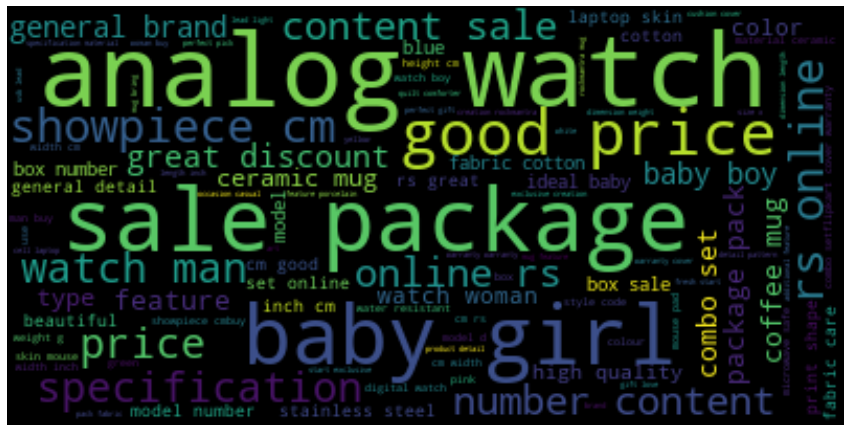

In [134]:
fig, ax = plt.subplots(1,1, figsize = (15,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

Cette visualisation nous donne une assez bonne idée de l'ensemble des mots présents dans ce corpus

## Exploration des données texte par LDA
Si les données textes sont capables de discriminer les 7 différentes catégories de produits il est possible que nous puissions observer des thèmes renvoyant à ces catégories au sein du texte.
- La LDA (latent Dirichlet Allocation) nous permet d'interpreter le corpus comme un mélange de différents thèmes, ces thèmes sont formés d'un groupe de mots qui les représentent

Formatage des données pour le traitement LDA

In [35]:
docList = [[token.text for token in nlp(doc)] for doc in cleanDocs2]

In [36]:
words = corpora.Dictionary(docList)
corpus = [words.doc2bow(doc) for doc in docList]

In [37]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=words,
                                            num_topics=7,  # le nombre de classes dont nous disposons
                                            random_state=2)

L'output de la LDA est sous la forme d'un ID, nous avons besoin de retransformer ce formatage en texte pour l'interpréter

In [38]:
lda_model.get_topic_terms(0)

[(18, 0.010011736),
 (104, 0.009579465),
 (26, 0.008318687),
 (65, 0.008243151),
 (2974, 0.008196632),
 (19, 0.007894117),
 (191, 0.006580825),
 (64, 0.006387991),
 (176, 0.006348918),
 (61, 0.0058545503)]

In [39]:
# fonction de 'traduction'
def translate_lda(topicTokenID):
    return(words.id2token[topicTokenID])

In [40]:
[translate_lda(lda_model.get_topic_terms(1,10)[i][0]) for i in range(10)]

['30',
 'price',
 'watch',
 'online',
 'analog',
 'good',
 'cm',
 'showpiece',
 'mug',
 'girl']

Nous construisons alors une fonction afin de faire ressortir des 10 tokens les plus caractéristiques d'un topic

In [41]:
def get_top_topic_tokens(topicID):
    topicDF = pd.DataFrame([lda_model.get_topic_terms(topicID,10)[i] for i in range(10)])
    topicDF.iloc[:,0] = [translate_lda(ID) for ID in topicDF.iloc[:,0]]
    topicDF.columns = ['Token','Poids']
    return(topicDF)

In [42]:
def plot_topic(topicDF,ax):
    sns.barplot(x= topicDF['Poids'],
                y = topicDF['Token'],
                ax=ax)
    ax.set_ylabel('')

Voici les résultats de notre modélisation en 7 topics du corpus:


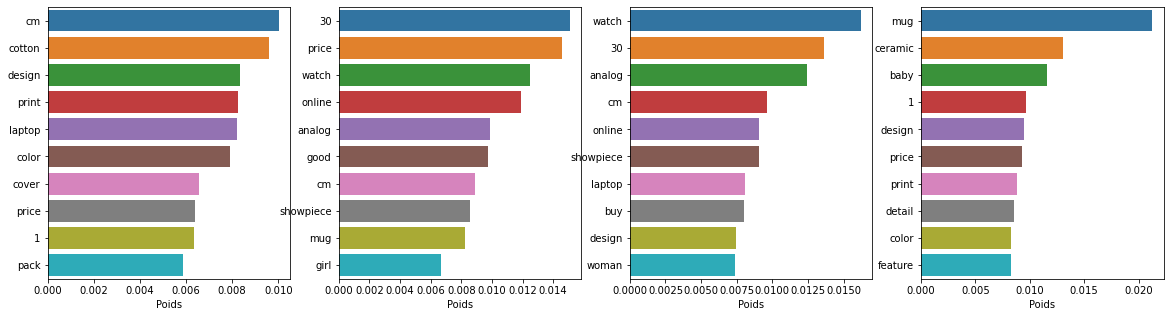

In [43]:
fig, ax = plt.subplots(1,4, figsize=(20,5))
plt.subplots_adjust(hspace=3)
for i in range(0,4):
    ax[i] = plot_topic(get_top_topic_tokens(i),ax[i])

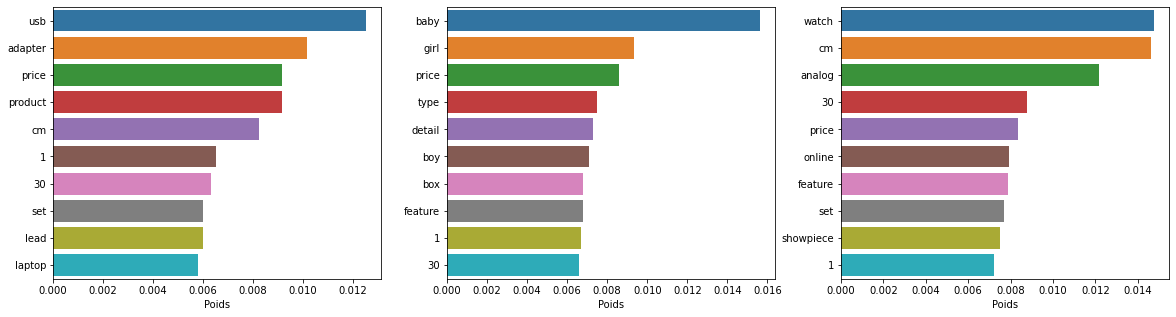

In [44]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
plt.subplots_adjust(hspace=3)
for i in range(0,3):
    ax[i] = plot_topic(get_top_topic_tokens(i+4),ax[i])

Il est difficile de voir une tendance émerger car les différents topics partagent de nombreux termes entre eux. 
- Nous allons tenter de faire un clustering sur les données avec une autre méthode : un clustering sur des score TF-IDF

## Calcul du score tf-idf
Le TF-IDF est une méthode permettant d'attribuer un score plus important aux mots fortement présents dans un document mais faiblement dans les autres
- Nous construisons notre matrice termes-documents sur la base de cette métrique

In [45]:
vectorizer = TfidfVectorizer()
tfIdfData = vectorizer.fit_transform(cleanDocs2)

In [46]:
tfIdfData.shape

(1050, 5637)

Notre encodage a construit un dataframe de 5637 colonnes

## Factorisation des features
- Nous essayons de réduire la dimensionnalité des données tout en conservant un maximum de la variance

In [47]:
def factorize(highColData):
    pcaData = PCA(n_components = 0.99) # Nous gardons 99% de la variance
    return(pcaData.fit_transform(highColData))

In [48]:
projectionTFIDF = factorize(tfIdfData.toarray())

In [49]:
projectionTFIDF.shape

(1050, 910)

In [50]:
print(f'Se débarasser de 1% des features les moins pertinents nous a permit de retirer {tfIdfData.shape[1] - projectionTFIDF.shape[1]} colonnes de données.')

Se débarasser de 1% des features les moins pertinents nous a permit de retirer 4727 colonnes de données.


## Fonction de clustering et mesure de la performance
Nous écrivons une fonction qui va nous permettre de visualiser et comparer les performance d'un clustering avec les mesures réelles

In [51]:
with warnings.catch_warnings(): # l'avertissement nous prévient seulement du changement de paramètres par défaut dans la prochaine version, nous le désactivons.

    def evaluate_clusterData(clusterData):

            model = KMeans(n_clusters=7,
                           random_state=2)
            clusterLabels = model.fit(clusterData).labels_
            ARI = adjusted_rand_score(data['encodedLabels'],clusterLabels)

            visualizer = TSNE(n_jobs=-1)

            X_tsne = visualizer.fit_transform(clusterData)
            vizData = pd.DataFrame(X_tsne)

            fig, ax = plt.subplots(1,2,
                                   figsize=(20,10))

            sns.scatterplot(x= vizData[0],
                            y= vizData[1],
                            hue=data['category'],
                            # L'ordre dans lequel les clusters vont être formés ne correspondra pas forcément au partitionnage réel
                            # Pour éviter une confusion dans l'interprétation nous utilisons deux palettes aux couleurs différentes
                            palette=sns.color_palette('tab10', n_colors=7), 
                            ax=ax[0])
            ax[0].set_title('Partitionnage réel')
            sns.scatterplot(x= vizData[0],
                            y= vizData[1],
                            hue=clusterLabels,
                            palette=sns.color_palette('Dark2',n_colors=7),
                            ax=ax[1]);
            ax[1].set_title('Partitionnage non supervisé')

            print(f'Le score ARI est égal à {ARI:.2f}')
warnings.simplefilter("ignore") 

Le score ARI est égal à 0.28


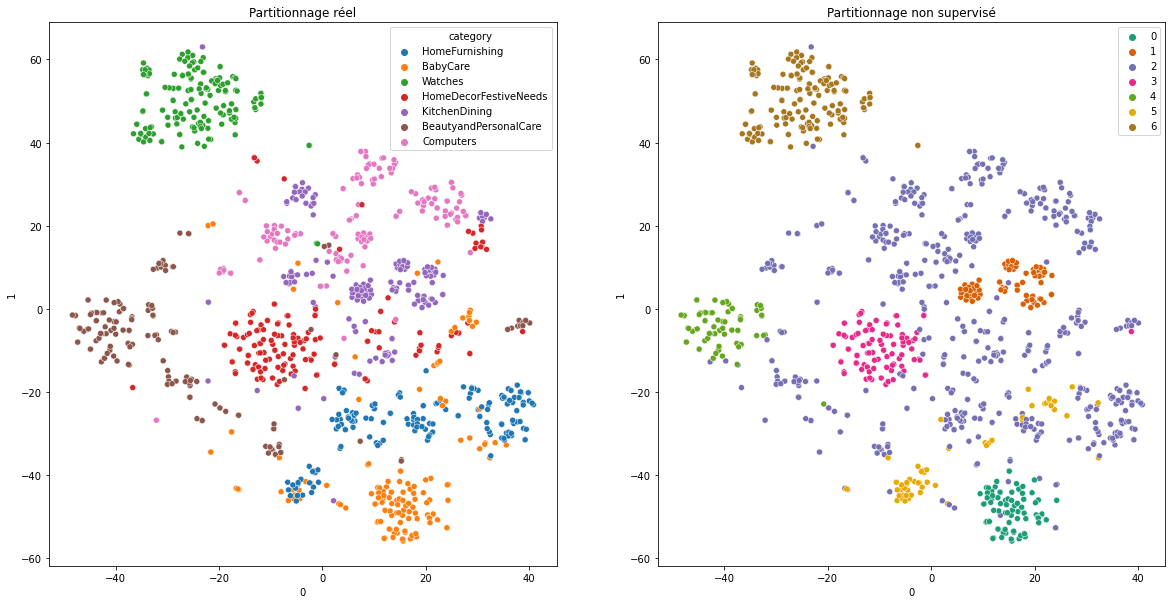

In [52]:
evaluate_clusterData(projectionTFIDF)

## Interprétation du contenu des clusters
Quels sont les mots représentatifs de ces clusters ? 
- Pourquoi certains sont ils mieux distingués que d'autres ? 

Nous construisons une fonction afin d'afficher pour chaque cluster les mots qui ont le plus haut score TF-IDF

In [53]:
# Copie des données TFIDF
labeledTFIDF = pd.DataFrame(tfIdfData.copy().toarray())

# Les colonnes de ce dataframe se voient leur nom ré-attribué
labeledTFIDF.columns = vectorizer.get_feature_names_out()

# Nous reproduisons l'entrainement sur les données factorisés
modelTFIDF = KMeans(n_clusters=7,
                           random_state=2)
TFIDFLabels = modelTFIDF.fit(projectionTFIDF).labels_

# Mais celà ne nous empêche pas d'assigner les labels sur les données dont les colonnes n'ont pas encore été transformées
labeledTFIDF['labels'] = TFIDFLabels

# Enfin nous regroupons les scores TF-IDF par label et les aggrégeons par valeur maximale
tokenRankingDF = labeledTFIDF.groupby('labels').max().T

Ce dataFrame peut alors être requété pour obtenir les termes au scores les plus élevés d'un cluster

In [54]:
def top_10_tokens(nCluster):
    return(tokenRankingDF[nCluster].sort_values(ascending=False)[0:10])

Nous pouvons observer que les clusters biens définis ont des termes assez consistants 

In [55]:
top_10_tokens(6)

77036sm02j    0.891632
7926sl01      0.887125
7007yl08      0.880141
7052ym07      0.880141
7016ym09      0.877838
7016ym04      0.877838
g16           0.840830
7085yl01      0.821970
8097ym03      0.804846
hmtwhq        0.802147
Name: 6, dtype: float64

Ici nous avons le format de références de montres 

In [56]:
top_10_tokens(0)

cap        0.661670
jegging    0.603749
pyjama     0.602017
line       0.579703
rute       0.569120
wow        0.566240
flare      0.565830
baby       0.565657
legging    0.558655
girl       0.540031
Name: 0, dtype: float64

Ici des termes relatifs à l'habillement et l'enfant 

In [171]:
top_10_tokens(2)

suruchi     0.778218
nirlon      0.778218
kalash      0.772782
su100       0.771033
shadow      0.765588
mykid       0.765106
binatone    0.762596
iball       0.762596
peacock     0.760185
kosher      0.760185
Name: 2, dtype: float64

En revanche, le cluster 2 qui semble avoir englobé une grande quantité d'instances contient surotut des mots relatifs à des marques.
- Si ces marques ont des produits disctribués dans différentes catégories celà pourrait expliquer la taille du cluster 2

## Extraction de features depuis les images
- nous allons utiliser la méthode ORB afin d'extraire des features depuis les images pour tenter de les classifier

In [58]:
path = 'Images/' # Les images sont dans un dossier à l'intérieur de notre environnement de travail

Notre image en entrée est sous cette forme classique

In [135]:
cv2

In [136]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)

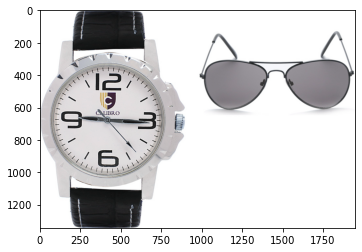

In [135]:
plt.imshow(cv2.imread((path+data['image'][10]);

Nous retirons la couleur (apparait jaune mais est en réalité un dégradé sur une seule teinte)

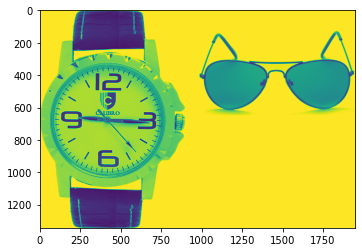

In [147]:
imgDemo = cv2.imread(path+data['image'][10],0)
plt.imshow(imgDemo);

Nous la normalisons la luminosité et augmentons le contraste pour faciliter l'entrainement

In [148]:
equalizedDemo = cv2.equalizeHist(imgDemo)

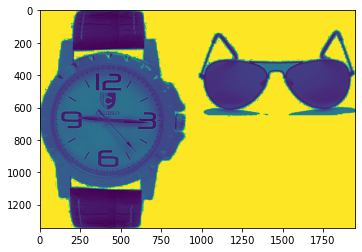

In [149]:
plt.imshow(equalizedDemo);

Nous itérons sur chaque image le traitement orb afin d'extraire des features


In [160]:
orb_keypoints = []
temps1=time.time()
orb = cv2.ORB_create(500)

for image_num in range(data.shape[0]) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path+data['image'][image_num],0) 
    res = cv2.equalizeHist(image)   
    kp, des = orb.detectAndCompute(res, None)
    orb_keypoints.append(des)

orb_keypoints_by_img = np.asarray(orb_keypoints)
orb_keypoints_all    = np.concatenate(orb_keypoints_by_img, axis=0)

print("Nombre de descripteurs : ", orb_keypoints_all.shape)

duration1=time.time()-temps1

print("temps de traitement ORB descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
Nombre de descripteurs :  (520145, 32)
temps de traitement ORB descriptor :            34.18 secondes


Il nous est possible de voir où sont situés les points considéré importants par le modèle

In [161]:
kp, des = orb.detectAndCompute(imgDemo,None)

In [162]:
kpDisplayDemo = cv2.drawKeypoints(imgDemo,kp,imgDemo)

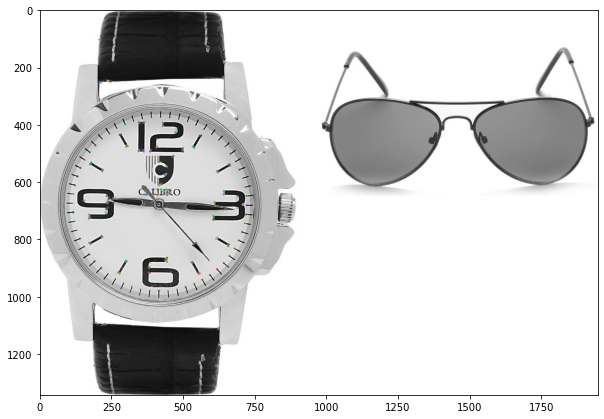

In [163]:
plt.figure(figsize=(10,10))
plt.imshow(kpDisplayDemo);

A cette distance ces derniers ne sont pas très visibles

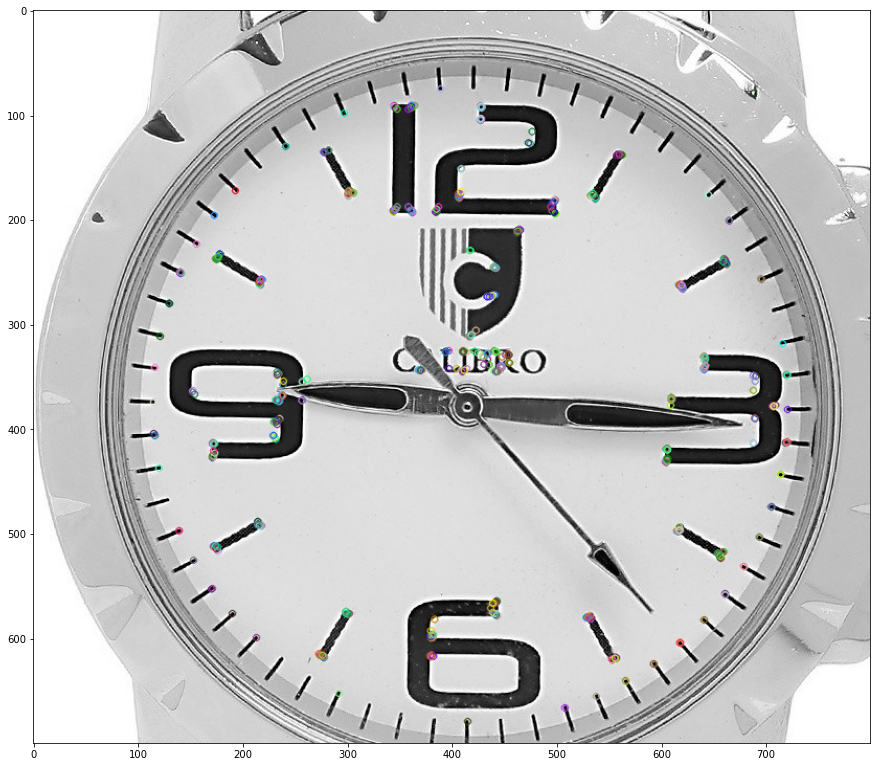

In [164]:
plt.figure(figsize=(15,15))
plt.imshow(kpDisplayDemo[300:1000,0:800]);

En zoomant ici sur le cadrant de cette montre nous pouvons voir que les graduations et différents angles sont mis en évidence

## Création des clusters de descripteurs
Nous faisons un clustering sur l'ensemble de ce "bag of visual words" afin d'être en mesure de prédire l'appartenance de chaque descripteur d'une image

In [165]:
temps1=time.time()

k = int(round(np.sqrt(len(orb_keypoints_all)),0)) # Nous choisissons de nous baser sur la racine carrée des keypoints pour notre nombre de clusters afin d'éviter de trop perdre d'information
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(orb_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  721
Création de 721 clusters de descripteurs ...
temps de traitement kmeans :             1.86 secondes


## Création des histogrammes par image
Nous comptons la quantité de features appartenant à un cluster donné présent dans une image
* Cette procédure va nous donner un histogramme représentant nos features pour chaque image

In [166]:
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des # égalisation de l'histogramme
    return hist


hist_vectors=[]

for i, image_desc in enumerate(orb_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) 
    hist_vectors.append(hist) 

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             2.57 secondes


## Factorisation des features

In [167]:
projectionImg = factorize(im_features)

In [168]:
projectionImg.shape

(1050, 576)

Le score ARI est égal à 0.03


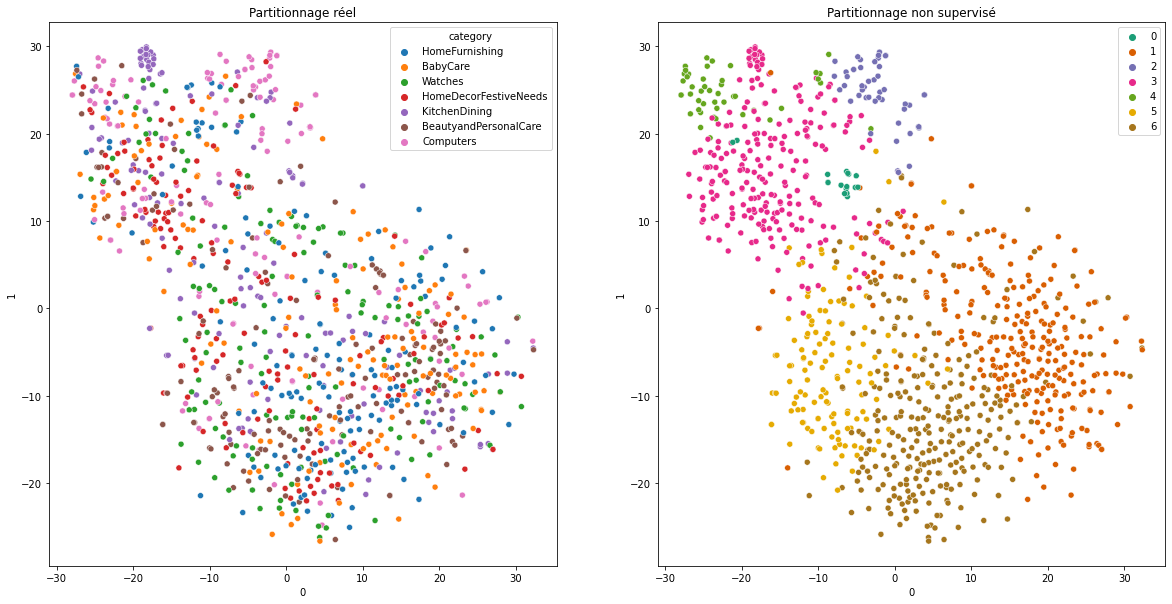

In [169]:
evaluate_clusterData(projectionImg)

Les résultats sont proches d'une répartition aléatoire. 

### Images + texte
Quelle performance pour un clustering basé sur les deux sources de données ensembles ?

Le score ARI est égal à 0.28


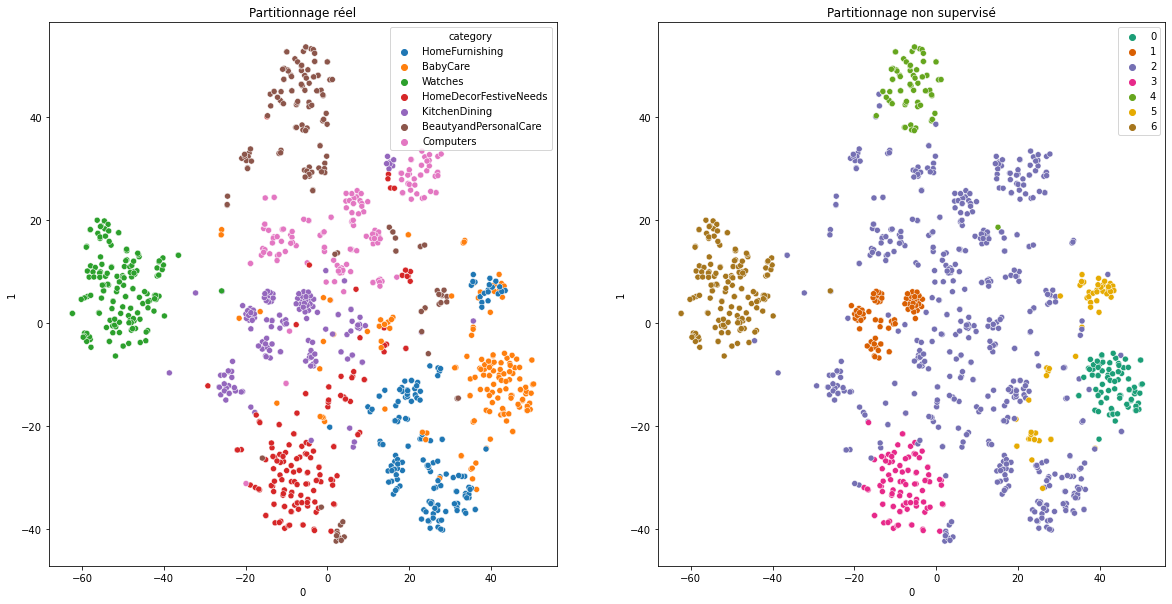

In [73]:
evaluate_clusterData(np.hstack([projectionTFIDF,projectionImg]))

Il semblerait que l'ajout des données visuelles n'ait pas apporté d'information en plus

# Transfer Learning 
Nous allons maintenant essayer d'appliquer les connaissances de modèles entrainés sur de plus grandes quantités de données à notre problématique

## Sur les données texte

### Utilisation de vecteurs pré entrainés
Les vecteurs du modèle 'en_core_web_lg'  
-   https://newreleases.io/project/github/explosion/spacy-models/release/en_core_web_lg-3.1.0

englobent un large vocabulaire basé sur plusieurs corpus de sources diverses
- le sens accumulé dans les 300 dimensions de cette vectorisation peut améliorer notre classification

In [74]:
def vectorize_text(Series):
    vectors = [nlp(doc).vector for doc in Series]
    return pd.DataFrame(vectors)

In [75]:
vectors = vectorize_text(cleanDocs2)

Le score ARI est égal à 0.49


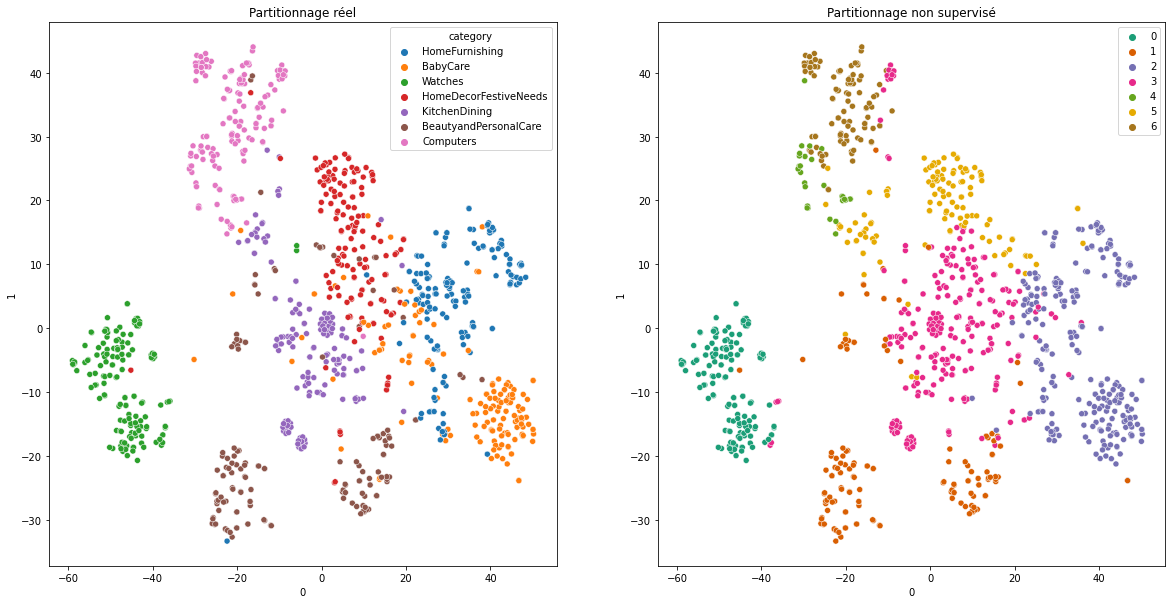

In [76]:
evaluate_clusterData(vectors)

Notre score est monté à 0.49, une nette amélioration

## Sur les données visuelles
Nous allons maintenant appliquer une méthode de transfer learning sur les données visuelles également afin de voir si nous pouvons encore améliorer la performance du clustering
- Le modèle que nous utilisons est le VGG16, un modèle fournit avec tensorflow qui a de bonnes performances dans la classification d'images

In [77]:
nnModel = VGG16()
nnModel = Model(inputs=nnModel.inputs, outputs=nnModel.layers[-2].output)
nnModel.summary()

2021-12-01 17:15:23.384529: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-01 17:15:23.386952: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/paul/anaconda3/lib/python3.8/site-packages/cv2/../../lib64:
2021-12-01 17:15:23.387279: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/paul/anaconda3/lib/python3.8/site-packages/cv2/../../lib64:
2021-12-01 17:15:23.387287: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries me

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Nous retirons la couche d'output qui sert à faire des prédictions sur un problème différent du notre
- l'idée est d'utiliser l'avant dernière couche du réseau pour tirer parti de son apprentissage lors de l'extraction des features

In [78]:
def VG16_extract_features(imgSeries):
    loadedImgs = [load_img(path+img, target_size=(224,224)) for img in imgSeries]
    arrayImgs = [img_to_array(img) for img in loadedImgs]
    reshapedArrays = [img.reshape(((1, img.shape[0], img.shape[1], img.shape[2]))) for img in arrayImgs]   
    features = []
    for i in range(len(reshapedArrays)):
        if i%100 == 0 : print(i)  
        features.append(nnModel.predict(reshapedArrays[i]).ravel())
        
    featuresDF = pd.DataFrame(features)
    return(featuresDF)

In [79]:
nnVisionFeatures = VG16_extract_features(data['image'])

0
100
200
300
400
500
600
700
800
900
1000


l'output est un vecteur de taille 4096 comme la dernière couche du modèle.

In [80]:
nnVisionFeatures.shape

(1050, 4096)

Nous le factorisons avant de le projeter.

In [81]:
projectionImgNN = factorize(nnVisionFeatures)

In [82]:
projectionImgNN.shape

(1050, 787)

Le score ARI est égal à 0.44


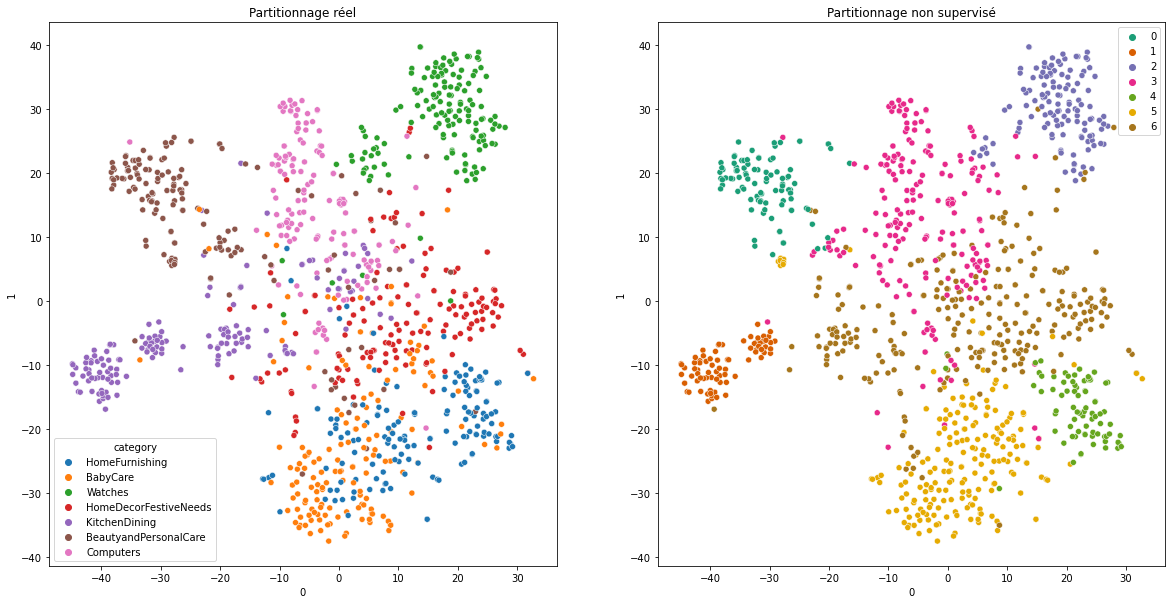

In [83]:
evaluate_clusterData(projectionImgNN)

Ici aussi la methode de transfert a permit d'améliorer les performances

Qu'en est-il de l'utilisation des données visuelles **et** texte pour le transfert ?

Le score ARI est égal à 0.44


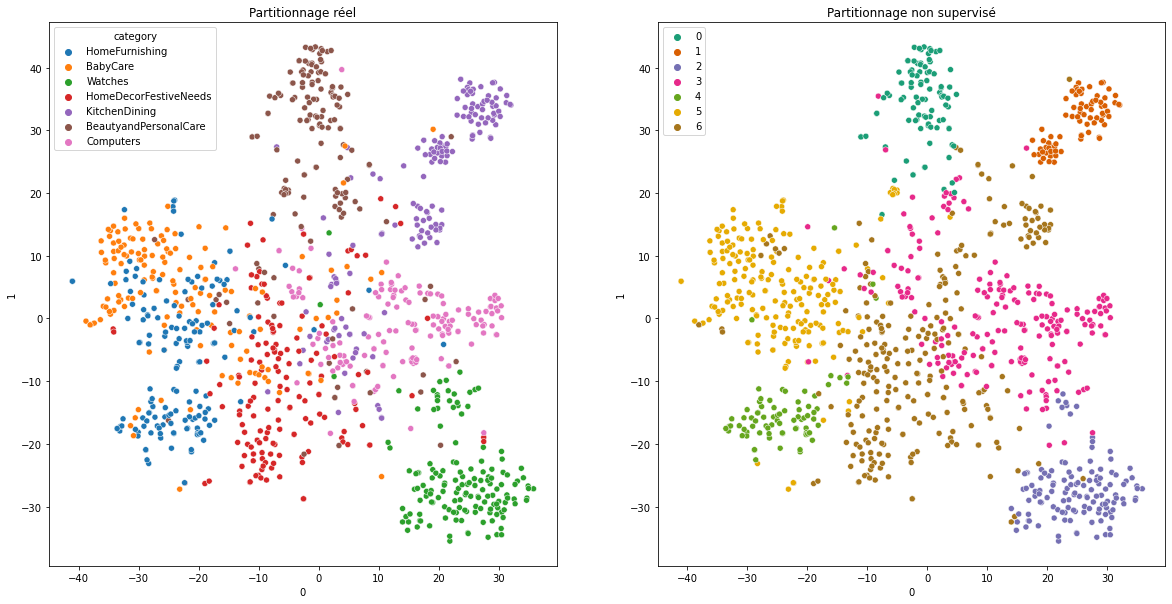

In [84]:
evaluate_clusterData(np.hstack([projectionImgNN,vectors]))

L'ajout des données visuelles semble faire baisser la performance du clustering.

## Evaluation des performances moyennes
Le résultat d'une mesure identique entre avec et sans les données visuelles est peut être un hasard
- Nous calculons le score ARI après avoir essayé plusieurs 'seed' d'initilisation afin d'avoir une idée plus fiable des réelles différences de performances des traitements

In [85]:
def mean_ARI(clusterData):
    ARIs = []
    for i in range(1,60):
        model = KMeans(n_clusters=7,
                       random_state=i)
        clusterLabels = model.fit(clusterData).labels_
        ARIs.append(adjusted_rand_score(data['encodedLabels'],clusterLabels))
    mean = np.mean(ARIs)
    return(mean)

In [86]:
preprocessingTechniques = {'TFIDF':projectionTFIDF,
                           'ORB':projectionImg,
                           'TFIDF + ORB':np.hstack([projectionTFIDF,projectionImg]),
                           'Transfer Vectors':vectors,
                           'Transfer CNN':projectionImgNN,
                           'Transfer CNN + Vectors':np.hstack([vectors,projectionImgNN])}

In [87]:
results = [mean_ARI(processedData) for processedData in preprocessingTechniques.values()]

In [88]:
perfDF = pd.DataFrame(results)
perfDF['méthode'] = preprocessingTechniques.keys()

In [89]:
perfDF.columns = ['ARI moyen', 'méthode']

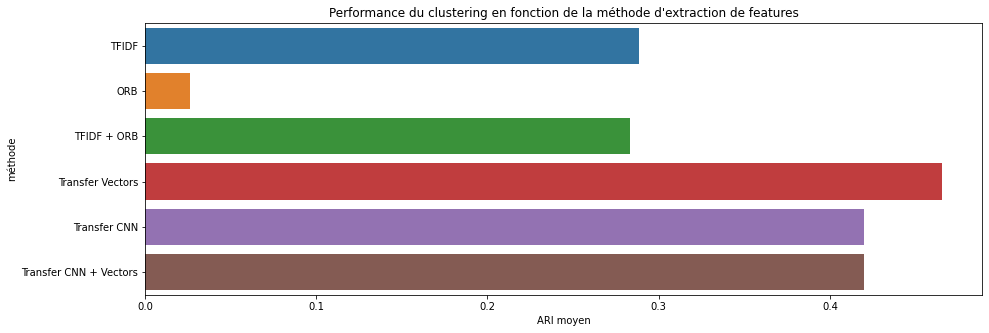

In [90]:
plt.figure(figsize=(15,5))
plt.title("Performance du clustering en fonction de la méthode d'extraction de features")
sns.barplot(x = 'ARI moyen',
            y = 'méthode',
            ci='sd',
            data=perfDF);

Il semblerait que l'effet soit robuste : L'utilisation de données texte en conjonction avec les données visuelles fait baisser la performance

Cependant, il est évident que les données texte et visuelles sont en mesure de fournir des informations sur la catégorie d'un produit peu importe la performance du clustering lorsque les deux sont mélangés.

Bien que d'après cette analyse il ne semble pas y avoir un intérêt à utiliser les deux types de données en même temps, il est probable qu'un modèle entrainé sur cette tâche en particulier puisse extraire de la performance en fusionnant les deux sources.

#### En conclusion:
- Les images et le texte contiennent des informations exploitables pour l'entrainement d'un modèle de classification.
- Cependant, l'utilité de fusionner les deux types de données reste à être déterminée.